In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import math
import heapq
import numpy as np
import os
import tensorflow as tf
from tensorflow.contrib.slim.python.slim.nets.inception_v3 import inception_v3_base
from matplotlib import pyplot as plt

C:\Users\A\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
FLAGS = tf.flags.FLAGS
slim = tf.contrib.slim

In [9]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)
    return keys_list,flags_dict

In [4]:
# configuration.py
class ModelConfig(object):
  """Wrapper class for model hyperparameters."""

  def __init__(self):
    """Sets the default model hyperparameters."""
    # File pattern of sharded TFRecord file containing SequenceExample protos.
    # Must be provided in training and evaluation modes.
    self.input_file_pattern = None

    # Image format ("jpeg" or "png").
    self.image_format = "jpeg"

    # Approximate number of values per input shard. Used to ensure sufficient
    # mixing between shards in training.
    self.values_per_input_shard = 2300
    # Minimum number of shards to keep in the input queue.
    self.input_queue_capacity_factor = 2
    # Number of threads for prefetching SequenceExample protos.
    self.num_input_reader_threads = 1

    # Name of the SequenceExample context feature containing image data.
    self.image_feature_name = "image/data"
    # Name of the SequenceExample feature list containing integer captions.
    self.caption_feature_name = "image/caption_ids"

    # Number of unique words in the vocab (plus 1, for <UNK>).
    # The default value is larger than the expected actual vocab size to allow
    # for differences between tokenizer versions used in preprocessing. There is
    # no harm in using a value greater than the actual vocab size, but using a
    # value less than the actual vocab size will result in an error.
    self.vocab_size = 12000

    # Number of threads for image preprocessing. Should be a multiple of 2.
    self.num_preprocess_threads = 4

    # Batch size.
    self.batch_size = 32

    # File containing an Inception v3 checkpoint to initialize the variables
    # of the Inception model. Must be provided when starting training for the
    # first time.
    self.inception_checkpoint_file = None

    # Dimensions of Inception v3 input images.
    self.image_height = 299
    self.image_width = 299

    # Scale used to initialize model variables.
    self.initializer_scale = 0.08

    # LSTM input and output dimensionality, respectively.
    self.embedding_size = 512
    self.num_lstm_units = 512

    # If < 1.0, the dropout keep probability applied to LSTM variables.
    self.lstm_dropout_keep_prob = 0.7

class TrainingConfig(object):
  """Wrapper class for training hyperparameters."""

  def __init__(self):
    """Sets the default training hyperparameters."""
    # Number of examples per epoch of training data.
    self.num_examples_per_epoch = 586363

    # Optimizer for training the model.
    self.optimizer = "SGD"

    # Learning rate for the initial phase of training.
    self.initial_learning_rate = 2.0
    self.learning_rate_decay_factor = 0.5
    self.num_epochs_per_decay = 8.0

    # Learning rate when fine tuning the Inception v3 parameters.
    self.train_inception_learning_rate = 0.0005

    # If not None, clip gradients to this value.
    self.clip_gradients = 5.0

    # How many model checkpoints to keep.
    self.max_checkpoints_to_keep = 5


# ops

# image_embedding.py
def inception_v3(images,
                 trainable=True,
                 is_training=True,
                 weight_decay=0.00004,
                 stddev=0.1,
                 dropout_keep_prob=0.8,
                 use_batch_norm=True,
                 batch_norm_params=None,
                 add_summaries=True,
                 scope="InceptionV3"):
    # Only consider the inception model to be in training mode if it's trainable.
    is_inception_model_training = trainable and is_training

    if use_batch_norm:
        # Default parameters for batch normalization.
        if not batch_norm_params:
            batch_norm_params = {
                "is_training": is_inception_model_training,
                "trainable": trainable,
                # Decay for the moving averages.
                "decay": 0.9997,
                # Epsilon to prevent 0s in variance.
                "epsilon": 0.001,
                # Collection containing the moving mean and moving variance.
                "variables_collections": {
                    "beta": None,
                    "gamma": None,
                    "moving_mean": ["moving_vars"],
                    "moving_variance": ["moving_vars"],
                }
            }
    else:
        batch_norm_params = None

    if trainable:
        weights_regularizer = tf.contrib.layers.l2_regularizer(weight_decay)
    else:
        weights_regularizer = None

    with tf.variable_scope(scope, "InceptionV3", [images]) as scope:
        with slim.arg_scope(
            [slim.conv2d, slim.fully_connected],
                weights_regularizer=weights_regularizer,
                trainable=trainable):
            with slim.arg_scope(
                [slim.conv2d],
                    weights_initializer=tf.truncated_normal_initializer(
                        stddev=stddev),
                    activation_fn=tf.nn.relu,
                    normalizer_fn=slim.batch_norm,
                    normalizer_params=batch_norm_params):
                net, end_points = inception_v3_base(images, scope=scope)
                with tf.variable_scope("logits"):
                    shape = net.get_shape()
                    net = slim.avg_pool2d(
                        net, shape[1:3], padding="VALID", scope="pool")
                    net = slim.dropout(
                        net,
                        keep_prob=dropout_keep_prob,
                        is_training=is_inception_model_training,
                        scope="dropout")
                    net = slim.flatten(net, scope="flatten")

    # Add summaries.
    if add_summaries:
        for v in end_points.values():
            tf.contrib.layers.summaries.summarize_activation(v)

    return net

# image_processing.py
def distort_image(image, thread_id):
    # Randomly flip horizontally.
    with tf.name_scope("flip_horizontal", values=[image]):
        image = tf.image.random_flip_left_right(image)

    # Randomly distort the colors based on thread id.
    color_ordering = thread_id % 2
    with tf.name_scope("distort_color", values=[image]):
        if color_ordering == 0:
            image = tf.image.random_brightness(image, max_delta=32. / 255.)
            image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
            image = tf.image.random_hue(image, max_delta=0.032)
            image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        elif color_ordering == 1:
            image = tf.image.random_brightness(image, max_delta=32. / 255.)
            image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
            image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
            image = tf.image.random_hue(image, max_delta=0.032)

        # The random_* ops do not necessarily clamp.
        image = tf.clip_by_value(image, 0.0, 1.0)

    return image

def process_image(encoded_image,
                  is_training,
                  height,
                  width,
                  resize_height=346,
                  resize_width=346,
                  thread_id=0,
                  image_format="jpeg"):
    # Helper function to log an image summary to the visualizer. Summaries are
    # only logged in thread 0.
    def image_summary(name, image):
        if not thread_id:
            tf.summary.image(name, tf.expand_dims(image, 0))

    # Decode image into a float32 Tensor of shape [?, ?, 3] with values in [0, 1).
    with tf.name_scope("decode", values=[encoded_image]):
        if image_format == "jpeg":
            image = tf.image.decode_jpeg(encoded_image, channels=3)
        elif image_format == "png":
            image = tf.image.decode_png(encoded_image, channels=3)
        else:
            raise ValueError("Invalid image format: %s" % image_format)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image_summary("original_image", image)

    # Resize image.
    assert (resize_height > 0) == (resize_width > 0)
    if resize_height:
        image = tf.image.resize_images(
            image,
            size=[resize_height, resize_width],
            method=tf.image.ResizeMethod.BILINEAR)

    # Crop to final dimensions.
    if is_training:
        image = tf.random_crop(image, [height, width, 3])
    else:
        # Central crop, assuming resize_height > height, resize_width > width.
        image = tf.image.resize_image_with_crop_or_pad(image, height, width)

    image_summary("resized_image", image)

    # Randomly distort the image.
    if is_training:
        image = distort_image(image, thread_id)

    image_summary("final_image", image)

    # Rescale to [-1,1] instead of [0, 1]
    image = tf.subtract(image, 0.5)
    image = tf.multiply(image, 2.0)
    return image

# inputs.py
def parse_sequence_example(serialized, image_feature, caption_feature):
    context, sequence = tf.parse_single_sequence_example(
        serialized,
        context_features={
            image_feature: tf.FixedLenFeature([], dtype=tf.string)
        },
        sequence_features={
            caption_feature: tf.FixedLenSequenceFeature([], dtype=tf.int64),
        })

    encoded_image = context[image_feature]
    caption = sequence[caption_feature]
    return encoded_image, caption

def prefetch_input_data(reader,
                        file_pattern,
                        is_training,
                        batch_size,
                        values_per_shard,
                        input_queue_capacity_factor=16,
                        num_reader_threads=1,
                        shard_queue_name="filename_queue",
                        value_queue_name="input_queue"):
    data_files = []
    for pattern in file_pattern.split(","):
        data_files.extend(tf.gfile.Glob(pattern))
    if not data_files:
        tf.logging.fatal("Found no input files matching %s", file_pattern)
    else:
        tf.logging.info("Prefetching values from %d files matching %s",
                        len(data_files), file_pattern)

    if is_training:
        filename_queue = tf.train.string_input_producer(
            data_files, shuffle=True, capacity=16, name=shard_queue_name)
        min_queue_examples = values_per_shard * input_queue_capacity_factor
        capacity = min_queue_examples + 100 * batch_size
        values_queue = tf.RandomShuffleQueue(
            capacity=capacity,
            min_after_dequeue=min_queue_examples,
            dtypes=[tf.string],
            name="random_" + value_queue_name)
    else:
        filename_queue = tf.train.string_input_producer(
            data_files, shuffle=False, capacity=1, name=shard_queue_name)
        capacity = values_per_shard + 3 * batch_size
        values_queue = tf.FIFOQueue(
            capacity=capacity,
            dtypes=[tf.string],
            name="fifo_" + value_queue_name)

    enqueue_ops = []
    for _ in range(num_reader_threads):
        _, value = reader.read(filename_queue)
        enqueue_ops.append(values_queue.enqueue([value]))
    tf.train.queue_runner.add_queue_runner(
        tf.train.queue_runner.QueueRunner(values_queue, enqueue_ops))
    tf.summary.scalar(
        "queue/%s/fraction_of_%d_full" % (values_queue.name, capacity),
        tf.cast(values_queue.size(), tf.float32) * (1. / capacity))

    return values_queue

def batch_with_dynamic_pad(images_and_captions,
                           batch_size,
                           queue_capacity,
                           add_summaries=True):
    enqueue_list = []
    for image, caption in images_and_captions:
        caption_length = tf.shape(caption)[0]
        input_length = tf.expand_dims(tf.subtract(caption_length, 1), 0)

        input_seq = tf.slice(caption, [0], input_length)
        target_seq = tf.slice(caption, [1], input_length)
        indicator = tf.ones(input_length, dtype=tf.int32)
        enqueue_list.append([image, input_seq, target_seq, indicator])

    images, input_seqs, target_seqs, mask = tf.train.batch_join(
        enqueue_list,
        batch_size=batch_size,
        capacity=queue_capacity,
        dynamic_pad=True,
        name="batch_and_pad")

    if add_summaries:
        lengths = tf.add(tf.reduce_sum(mask, 1), 1)
        tf.summary.scalar("caption_length/batch_min", tf.reduce_min(lengths))
        tf.summary.scalar("caption_length/batch_max", tf.reduce_max(lengths))
        tf.summary.scalar("caption_length/batch_mean", tf.reduce_mean(lengths))

    return images, input_seqs, target_seqs, mask


# inference_utils

# caption_generator.py
class Caption(object):
    def __init__(self, sentence, state, logprob, score, metadata=None):

        self.sentence = sentence
        self.state = state
        self.logprob = logprob
        self.score = score
        self.metadata = metadata

    def __cmp__(self, other):
        assert isinstance(other, Caption)
        if self.score == other.score:
            return 0
        elif self.score < other.score:
            return -1
        else:
            return 1

    # For Python 3 compatibility (__cmp__ is deprecated).
    def __lt__(self, other):
        assert isinstance(other, Caption)
        return self.score < other.score

    # Also for Python 3 compatibility.
    def __eq__(self, other):
        assert isinstance(other, Caption)
        return self.score == other.score

class TopN(object):
    def __init__(self, n):
        self._n = n
        self._data = []

    def size(self):
        assert self._data is not None
        return len(self._data)

    def push(self, x):
        """Pushes a new element."""
        assert self._data is not None
        if len(self._data) < self._n:
            heapq.heappush(self._data, x)
        else:
            heapq.heappushpop(self._data, x)

    def extract(self, sort=False):
        assert self._data is not None
        data = self._data
        self._data = None
        if sort:
            data.sort(reverse=True)
        return data

    def reset(self):
        self._data = []

class CaptionGenerator(object):
    def __init__(self,
                 model,
                 vocab,
                 beam_size=3,
                 max_caption_length=20,
                 length_normalization_factor=0.0):
        self.vocab = vocab
        self.model = model

        self.beam_size = beam_size
        self.max_caption_length = max_caption_length
        self.length_normalization_factor = length_normalization_factor

    def beam_search(self, sess, encoded_image):
        # Feed in the image to get the initial state.
        initial_state = self.model.feed_image(sess, encoded_image)

        initial_beam = Caption(
            sentence=[self.vocab.start_id],
            state=initial_state[0],
            logprob=0.0,
            score=0.0,
            metadata=[""])
        partial_captions = TopN(self.beam_size)
        partial_captions.push(initial_beam)
        complete_captions = TopN(self.beam_size)

        # Run beam search.
        for _ in range(self.max_caption_length - 1):
            partial_captions_list = partial_captions.extract()
            partial_captions.reset()
            input_feed = np.array(
                [c.sentence[-1] for c in partial_captions_list])
            state_feed = np.array([c.state for c in partial_captions_list])

            softmax, new_states, metadata = self.model.inference_step(
                sess, input_feed, state_feed)

            for i, partial_caption in enumerate(partial_captions_list):
                word_probabilities = softmax[i]
                state = new_states[i]
                # For this partial caption, get the beam_size most probable next words.
                words_and_probs = list(enumerate(word_probabilities))
                words_and_probs.sort(key=lambda x: -x[1])
                words_and_probs = words_and_probs[0:self.beam_size]
                # Each next word gives a new partial caption.
                for w, p in words_and_probs:
                    if p < 1e-12:
                        continue  # Avoid log(0).
                    sentence = partial_caption.sentence + [w]
                    logprob = partial_caption.logprob + math.log(p)
                    score = logprob
                    if metadata:
                        metadata_list = partial_caption.metadata + [
                            metadata[i]
                        ]
                    else:
                        metadata_list = None
                    if w == self.vocab.end_id:
                        if self.length_normalization_factor > 0:
                            score /= len(
                                sentence)**self.length_normalization_factor
                        beam = Caption(sentence, state, logprob, score,
                                       metadata_list)
                        complete_captions.push(beam)
                    else:
                        beam = Caption(sentence, state, logprob, score,
                                       metadata_list)
                        partial_captions.push(beam)
            if partial_captions.size() == 0:
                # We have run out of partial candidates; happens when beam_size = 1.
                break

        # If we have no complete captions then fall back to the partial captions.
        # But never output a mixture of complete and partial captions because a
        # partial caption could have a higher score than all the complete captions.
        if not complete_captions.size():
            complete_captions = partial_captions

        return complete_captions.extract(sort=True)

# inference_wrapper_base.py
class InferenceWrapperBase(object):
    def __init__(self):
        pass

    def build_model(self, model_config):
        tf.logging.fatal("Please implement build_model in subclass")

    def _create_restore_fn(self, checkpoint_path, saver):
        if tf.gfile.IsDirectory(checkpoint_path):
            checkpoint_path = tf.train.latest_checkpoint(checkpoint_path)
            if not checkpoint_path:
                raise ValueError(
                    "No checkpoint file found in: %s" % checkpoint_path)

        def _restore_fn(sess):
            tf.logging.info("Loading model from checkpoint: %s",
                            checkpoint_path)
            saver.restore(sess, checkpoint_path)
            tf.logging.info("Successfully loaded checkpoint: %s",
                            os.path.basename(checkpoint_path))

        return _restore_fn

    def build_graph_from_config(self, model_config, checkpoint_path):
        tf.logging.info("Building model.")
        self.build_model(model_config)
        saver = tf.train.Saver()

        return self._create_restore_fn(checkpoint_path, saver)

    def build_graph_from_proto(self, graph_def_file, saver_def_file,
                               checkpoint_path):
        # Load the Graph.
        tf.logging.info("Loading GraphDef from file: %s", graph_def_file)
        graph_def = tf.GraphDef()
        with tf.gfile.FastGFile(graph_def_file, "rb") as f:
            graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name="")

        # Load the Saver.
        tf.logging.info("Loading SaverDef from file: %s", saver_def_file)
        saver_def = tf.train.SaverDef()
        with tf.gfile.FastGFile(saver_def_file, "rb") as f:
            saver_def.ParseFromString(f.read())
        saver = tf.train.Saver(saver_def=saver_def)

        return self._create_restore_fn(checkpoint_path, saver)

    def feed_image(self, sess, encoded_image):
        tf.logging.fatal("Please implement feed_image in subclass")

    def inference_step(self, sess, input_feed, state_feed):
        tf.logging.fatal("Please implement inference_step in subclass")

# vocabulary.py
class Vocabulary(object):

    def __init__(self,
                 vocab_file,
                 start_word="<S>",
                 end_word="</S>",
                 unk_word="<UNK>"):
        if not tf.gfile.Exists(vocab_file):
            tf.logging.fatal("Vocab file %s not found.", vocab_file)
        tf.logging.info("Initializing vocabulary from file: %s", vocab_file)

        with tf.gfile.GFile(vocab_file, mode="r") as f:
            reverse_vocab = list(f.readlines())
        reverse_vocab = [line.split()[0] for line in reverse_vocab]
        assert start_word in reverse_vocab
        assert end_word in reverse_vocab
        if unk_word not in reverse_vocab:
            reverse_vocab.append(unk_word)
        vocab = dict([(x, y) for (y, x) in enumerate(reverse_vocab)])

        tf.logging.info("Created vocabulary with %d words" % len(vocab))

        self.vocab = vocab  # vocab[word] = id
        self.reverse_vocab = reverse_vocab  # reverse_vocab[id] = word

        # Save special word ids.
        self.start_id = vocab[start_word]
        self.end_id = vocab[end_word]
        self.unk_id = vocab[unk_word]

    def word_to_id(self, word):
        """Returns the integer word id of a word string."""
        if word in self.vocab:
            return self.vocab[word]
        else:
            return self.unk_id

    def id_to_word(self, word_id):
        """Returns the word string of an integer word id."""
        if word_id >= len(self.reverse_vocab):
            return self.reverse_vocab[self.unk_id]
        else:
            return self.reverse_vocab[word_id]


# show_and_tell_model.py
class ShowAndTellModel(object):

    def __init__(self, config, mode, train_inception=False):
        assert mode in ["train", "eval", "inference"]
        self.config = config
        self.mode = mode
        self.train_inception = train_inception

        # Reader for the input data.
        self.reader = tf.TFRecordReader()

        # To match the "Show and Tell" paper we initialize all variables with a
        # random uniform initializer.
        self.initializer = tf.random_uniform_initializer(
            minval=-self.config.initializer_scale,
            maxval=self.config.initializer_scale)

        # A float32 Tensor with shape [batch_size, height, width, channels].
        self.images = None

        # An int32 Tensor with shape [batch_size, padded_length].
        self.input_seqs = None

        # An int32 Tensor with shape [batch_size, padded_length].
        self.target_seqs = None

        # An int32 0/1 Tensor with shape [batch_size, padded_length].
        self.input_mask = None

        # A float32 Tensor with shape [batch_size, embedding_size].
        self.image_embeddings = None

        # A float32 Tensor with shape [batch_size, padded_length, embedding_size].
        self.seq_embeddings = None

        # A float32 scalar Tensor; the total loss for the trainer to optimize.
        self.total_loss = None

        # A float32 Tensor with shape [batch_size * padded_length].
        self.target_cross_entropy_losses = None

        # A float32 Tensor with shape [batch_size * padded_length].
        self.target_cross_entropy_loss_weights = None

        # Collection of variables from the inception submodel.
        self.inception_variables = []

        # Function to restore the inception submodel from checkpoint.
        self.init_fn = None

        # Global step Tensor.
        self.global_step = None

    def is_training(self):
        """Returns true if the model is built for training mode."""
        return self.mode == "train"

    def process_image(self, encoded_image, thread_id=0):
        return process_image(
            encoded_image,
            is_training=self.is_training(),
            height=self.config.image_height,
            width=self.config.image_width,
            thread_id=thread_id,
            image_format=self.config.image_format)

    def build_inputs(self):
        if self.mode == "inference":
            # In inference mode, images and inputs are fed via placeholders.
            image_feed = tf.placeholder(
                dtype=tf.string, shape=[], name="image_feed")
            input_feed = tf.placeholder(
                dtype=tf.int64,
                shape=[None],  # batch_size
                name="input_feed")

            # Process image and insert batch dimensions.
            images = tf.expand_dims(self.process_image(image_feed), 0)
            input_seqs = tf.expand_dims(input_feed, 1)

            # No target sequences or input mask in inference mode.
            target_seqs = None
            input_mask = None
        else:
            # Prefetch serialized SequenceExample protos.
            input_queue = prefetch_input_data(
                self.reader,
                self.config.input_file_pattern,
                is_training=self.is_training(),
                batch_size=self.config.batch_size,
                values_per_shard=self.config.values_per_input_shard,
                input_queue_capacity_factor=self.config.
                input_queue_capacity_factor,
                num_reader_threads=self.config.num_input_reader_threads)

            # Image processing and random distortion. Split across multiple threads
            # with each thread applying a slightly different distortion.
            assert self.config.num_preprocess_threads % 2 == 0
            images_and_captions = []
            for thread_id in range(self.config.num_preprocess_threads):
                serialized_sequence_example = input_queue.dequeue()
                encoded_image, caption = parse_sequence_example(
                    serialized_sequence_example,
                    image_feature=self.config.image_feature_name,
                    caption_feature=self.config.caption_feature_name)
                image = self.process_image(encoded_image, thread_id=thread_id)
                images_and_captions.append([image, caption])

            # Batch inputs.
            queue_capacity = (2 * self.config.num_preprocess_threads *
                              self.config.batch_size)
            images, input_seqs, target_seqs, input_mask = (
                batch_with_dynamic_pad(
                    images_and_captions,
                    batch_size=self.config.batch_size,
                    queue_capacity=queue_capacity))

        self.images = images
        self.input_seqs = input_seqs
        self.target_seqs = target_seqs
        self.input_mask = input_mask

    def build_image_embeddings(self):
        inception_output = inception_v3(
            self.images,
            trainable=self.train_inception,
            is_training=self.is_training())
        self.inception_variables = tf.get_collection(
            tf.GraphKeys.GLOBAL_VARIABLES, scope="InceptionV3")

        # Map inception output into embedding space.
        with tf.variable_scope("image_embedding") as scope:
            image_embeddings = tf.contrib.layers.fully_connected(
                inputs=inception_output,
                num_outputs=self.config.embedding_size,
                activation_fn=None,
                weights_initializer=self.initializer,
                biases_initializer=None,
                scope=scope)

        # Save the embedding size in the graph.
        tf.constant(self.config.embedding_size, name="embedding_size")

        self.image_embeddings = image_embeddings

    def build_seq_embeddings(self):
        with tf.variable_scope("seq_embedding"), tf.device("/cpu:0"):
            embedding_map = tf.get_variable(
                name="map",
                shape=[self.config.vocab_size, self.config.embedding_size],
                initializer=self.initializer)
            seq_embeddings = tf.nn.embedding_lookup(embedding_map,
                                                    self.input_seqs)

        self.seq_embeddings = seq_embeddings

    def build_model(self):
        # This LSTM cell has biases and outputs tanh(new_c) * sigmoid(o), but the
        # modified LSTM in the "Show and Tell" paper has no biases and outputs
        # new_c * sigmoid(o).
        lstm_cell = tf.contrib.rnn.BasicLSTMCell(
            num_units=self.config.num_lstm_units, state_is_tuple=True)
        if self.mode == "train":
            lstm_cell = tf.contrib.rnn.DropoutWrapper(
                lstm_cell,
                input_keep_prob=self.config.lstm_dropout_keep_prob,
                output_keep_prob=self.config.lstm_dropout_keep_prob)

        with tf.variable_scope(
                "lstm", initializer=self.initializer) as lstm_scope:
            # Feed the image embeddings to set the initial LSTM state.
            zero_state = lstm_cell.zero_state(
                batch_size=self.image_embeddings.get_shape()[0],
                dtype=tf.float32)
            _, initial_state = lstm_cell(self.image_embeddings, zero_state)

            # Allow the LSTM variables to be reused.
            lstm_scope.reuse_variables()

            if self.mode == "inference":
                # In inference mode, use concatenated states for convenient feeding and
                # fetching.
                tf.concat(axis=1, values=initial_state, name="initial_state")

                # Placeholder for feeding a batch of concatenated states.
                state_feed = tf.placeholder(
                    dtype=tf.float32,
                    shape=[None, sum(lstm_cell.state_size)],
                    name="state_feed")
                state_tuple = tf.split(
                    value=state_feed, num_or_size_splits=2, axis=1)

                # Run a single LSTM step.
                lstm_outputs, state_tuple = lstm_cell(
                    inputs=tf.squeeze(self.seq_embeddings, axis=[1]),
                    state=state_tuple)

                # Concatentate the resulting state.
                tf.concat(axis=1, values=state_tuple, name="state")
            else:
                # Run the batch of sequence embeddings through the LSTM.
                sequence_length = tf.reduce_sum(self.input_mask, 1)
                lstm_outputs, _ = tf.nn.dynamic_rnn(
                    cell=lstm_cell,
                    inputs=self.seq_embeddings,
                    sequence_length=sequence_length,
                    initial_state=initial_state,
                    dtype=tf.float32,
                    scope=lstm_scope)

        # Stack batches vertically.
        lstm_outputs = tf.reshape(lstm_outputs, [-1, lstm_cell.output_size])

        with tf.variable_scope("logits") as logits_scope:
            logits = tf.contrib.layers.fully_connected(
                inputs=lstm_outputs,
                num_outputs=self.config.vocab_size,
                activation_fn=None,
                weights_initializer=self.initializer,
                scope=logits_scope)

        if self.mode == "inference":
            tf.nn.softmax(logits, name="softmax")
        else:
            targets = tf.reshape(self.target_seqs, [-1])
            weights = tf.to_float(tf.reshape(self.input_mask, [-1]))

            # Compute losses.
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=targets, logits=logits)
            batch_loss = tf.div(
                tf.reduce_sum(tf.multiply(losses, weights)),
                tf.reduce_sum(weights),
                name="batch_loss")
            tf.losses.add_loss(batch_loss)
            total_loss = tf.losses.get_total_loss()

            # Add summaries.
            tf.summary.scalar("losses/batch_loss", batch_loss)
            tf.summary.scalar("losses/total_loss", total_loss)
            for var in tf.trainable_variables():
                tf.summary.histogram("parameters/" + var.op.name, var)

            self.total_loss = total_loss
            self.target_cross_entropy_losses = losses  # Used in evaluation.
            self.target_cross_entropy_loss_weights = weights  # Used in evaluation.

    def setup_inception_initializer(self):
        """Sets up the function to restore inception variables from checkpoint."""
        if self.mode != "inference":
            # Restore inception variables only.
            saver = tf.train.Saver(self.inception_variables)

            def restore_fn(sess):
                tf.logging.info(
                    "Restoring Inception variables from checkpoint file %s",
                    self.config.inception_checkpoint_file)
                saver.restore(sess, self.config.inception_checkpoint_file)

            self.init_fn = restore_fn

    def setup_global_step(self):
        """Sets up the global step Tensor."""
        global_step = tf.Variable(
            initial_value=0,
            name="global_step",
            trainable=False,
            collections=[
                tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES
            ])

        self.global_step = global_step

    def build(self):
        """Creates all ops for training and evaluation."""
        self.build_inputs()
        self.build_image_embeddings()
        self.build_seq_embeddings()
        self.build_model()
        self.setup_inception_initializer()
        self.setup_global_step()


# inference_wrapper.py
class InferenceWrapper(InferenceWrapperBase):
    """Model wrapper class for performing inference with a ShowAndTellModel."""

    def __init__(self):
        super(InferenceWrapper, self).__init__()

    def build_model(self, model_config):
        model = ShowAndTellModel(
            model_config, mode="inference")
        model.build()
        return model

    def feed_image(self, sess, encoded_image):
        initial_state = sess.run(
            fetches="lstm/initial_state:0",
            feed_dict={"image_feed:0": encoded_image})
        return initial_state

    def inference_step(self, sess, input_feed, state_feed):
        softmax_output, state_output = sess.run(
            fetches=["softmax:0", "lstm/state:0"],
            feed_dict={
                "input_feed:0": input_feed,
                "lstm/state_feed:0": state_feed,
            })
        return softmax_output, state_output, None

In [13]:
def showandtell(_):
    del_all_flags(FLAGS)
    tf.flags.DEFINE_string("checkpoint_path", "./model.ckpt-2000000",
                       "Model checkpoint file or directory containing a "
                       "model checkpoint file.")
    tf.flags.DEFINE_string("vocab_file", "./word_counts.txt", "Text file containing the vocabulary.")
    tf.logging.set_verbosity(tf.logging.INFO)
    # Build the inference graph.
    g = tf.Graph()
    with g.as_default():
        model = InferenceWrapper()
        restore_fn = model.build_graph_from_config(ModelConfig(),
                                                   FLAGS.checkpoint_path)
    g.finalize()

    # Create the vocabulary.
    vocab = Vocabulary(FLAGS.vocab_file)
    with tf.Session(graph=g) as sess:
        restore_fn(sess)
        generator = CaptionGenerator(model, vocab)
        num = input('Enter number of file: ')
        tf.flags.DEFINE_string("input_files", "./outdoor_images/" + str(num) + ".jpg","File pattern or comma-separated list of file patterns of image files.")
        with tf.gfile.GFile(FLAGS.input_files, "rb") as f:
            image = f.read()
            captions = generator.beam_search(sess, image)
            img = plt.imread('outdoor_images/' + str(num) + '.jpg')
            plt.figure()
            plt.imshow(img)
            plt.show()
            print("Caption for image %s:" % os.path.basename(FLAGS.input_files))
            for i, caption in enumerate(captions):
                # Ignore begin and end words.
                sentence = [vocab.id_to_word(w) for w in caption.sentence[1:-1]]
                sentence = " ".join(sentence)
                print("  %d) %s (p=%f)" % (i, sentence, math.exp(caption.logprob)))
            FLAGS.__delattr__('input_files')

INFO:tensorflow:Building model.
INFO:tensorflow:Initializing vocabulary from file: ./word_counts.txt
INFO:tensorflow:Created vocabulary with 11520 words
INFO:tensorflow:Loading model from checkpoint: ./model.ckpt-2000000
INFO:tensorflow:Restoring parameters from ./model.ckpt-2000000
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-2000000
Enter number of file: 6


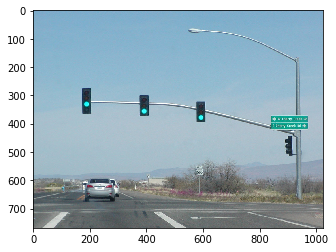

Caption for image 6.jpg:
  0) a traffic light sitting on the side of a road . (p=0.001797)
  1) a traffic light sitting on the side of a street . (p=0.000310)
  2) a traffic light sitting on the side of the road . (p=0.000144)
Exiting.


In [14]:
try:
    tf.app.run(showandtell)
except SystemExit:
    print("Exiting.")